##We are going to predict remaining useful lifetime (RUL) of a turbofan engine based on C-MAPSS data (Sensors and operating settings) using LSTM model  

##Importing necessary librairies 

In [9]:
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt

from matplotlib import rcParams

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score as accuracy
from sklearn.metrics import recall_score as recall
from sklearn.metrics import precision_score as precision
from sklearn.metrics import f1_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import os
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
import tensorflow as tf 
from sklearn.decomposition import PCA
import seaborn as sns


In [10]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking, TimeDistributed

##Exploratory Data Analysis 

In [11]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [12]:
x = ['sensor_' + str(i) for i in range(1, 22)]
col_names = ['unit_number', 'time_cycles', 'op_setting_1', 'op_setting_2', 'op_setting_3'] + x

###Please import dataset wherever you've stored it, or you could download it here: https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/#turbofan

In [13]:
train_01 = pd.read_csv('/content/drive/My Drive/Booz Allen/CMAPSSData/train_FD001.txt', delim_whitespace=True, header = None, names = col_names)

In [14]:
test_01 = pd.read_csv('/content/drive/My Drive/Booz Allen/CMAPSSData/test_FD001.txt', delim_whitespace=True, header = None, names = col_names)

In [15]:
rul_01 = pd.read_csv('/content/drive/My Drive/Booz Allen/CMAPSSData/RUL_FD001.txt', delim_whitespace=True, header = None)

##Data Preprocessing 

In [16]:
def add_operating_condition(df):
    df_op_cond = df.copy()
    
    df_op_cond['op_setting_1'] = df_op_cond['op_setting_1'].round()
    df_op_cond['op_setting_2'] = df_op_cond['op_setting_2'].round(decimals=2)
    
    # converting settings to string and concatanating makes the operating condition into a categorical variable
    df_op_cond['op_cond'] = df_op_cond['op_setting_1'].astype(str) + '_' + \
                        df_op_cond['op_setting_2'].astype(str) + '_' + \
                        df_op_cond['op_setting_3'].astype(str)
    
    return df_op_cond

def condition_scaler(df_train, df_test, sensor_names):
    # apply operating condition specific scaling
    scaler = StandardScaler()
    for condition in df_train['op_cond'].unique():
        scaler.fit(df_train.loc[df_train['op_cond']==condition, sensor_names])
        df_train.loc[df_train['op_cond']==condition, sensor_names] = scaler.transform(df_train.loc[df_train['op_cond']==condition, sensor_names])
        df_test.loc[df_test['op_cond']==condition, sensor_names] = scaler.transform(df_test.loc[df_test['op_cond']==condition, sensor_names])
    return df_train, df_test

In [17]:
def exponential_smoothing(df, sensors, n_samples, alpha=0.4):
    df = df.copy()
    # first, take the exponential weighted mean
    df[sensors] = df.groupby('unit_number')[sensors].apply(lambda x: x.ewm(alpha=alpha).mean())
    # second, drop first n_samples of each unit_nr to reduce filter delay
    def create_mask(data, samples):
        result = np.ones_like(data)
        result[0:samples] = 0
        return result
    
    mask = df.groupby('unit_number')['unit_number'].transform(create_mask, samples=n_samples).astype(bool).reset_index(drop=True)
    df = df[mask.iloc[:, 0]]
    
    return df

In [18]:
gss = GroupShuffleSplit(n_splits=1, train_size=0.80, random_state=42)  # eventhough we set np and tf seeds, gss requires its own seed

def train_val_group_split(X, y, gss, groups, print_groups=True):
    
    for idx_train, idx_val in gss.split(X, y, groups=groups):
        if print_groups:
            print('train_split_engines', train.iloc[idx_train]['unit_nr'].unique())
            print('validate_split_engines', train.iloc[idx_val]['unit_nr'].unique(), '\n')

        X_train_split = X.iloc[idx_train].copy()
        y_train_split = y.iloc[idx_train].copy()
        X_val_split = X.iloc[idx_val].copy()
        y_val_split = y.iloc[idx_val].copy()
    return X_train_split, y_train_split, X_val_split, y_val_split

###This function creates3D sequences of data , So far our data is 2D our model GRU needs 3D data ==> the sequences here are created only for one engine unit 

In [19]:
def gen_train_data(df, sequence_length, columns):
    data = df[columns].values
    num_elements = data.shape[0]

    # -1 and +1 because of Python indexing
    for start, stop in zip(range(0, num_elements-(sequence_length-1)), range(sequence_length, num_elements+1)):
        yield data[start:stop, :]


###Generate sequences for all engine units 

In [20]:
def gen_data_wrapper(df, sequence_length, columns, unit_nrs=np.array([])):
    if unit_nrs.size <= 0:
        unit_nrs = df['unit_number'].unique()
        
    data_gen = (list(gen_train_data(df[df['unit_number']==unit_nr], sequence_length, columns))
               for unit_nr in unit_nrs)
    data_array = np.concatenate(list(data_gen)).astype(np.float32)
    return data_array

###Generete sequences for labels, labels are what we are predicting

In [21]:
def gen_labels(df, sequence_length, label):
    data_matrix = df[label].values
    num_elements = data_matrix.shape[0]

    # -1 because I want to predict the rul of that last row in the sequence, not the next row
    return data_matrix[sequence_length-1:num_elements, :]  

def gen_label_wrapper(df, sequence_length, label, unit_nrs=np.array([])):
    if unit_nrs.size <= 0:
        unit_nrs = df['unit_number'].unique()
        
    label_gen = [gen_labels(df[df['unit_number']==unit_nr], sequence_length, label) 
                for unit_nr in unit_nrs]
    label_array = np.concatenate(label_gen).astype(np.float32)
    return label_array

In [22]:
def gen_test_data(df, sequence_length, columns, mask_value):
    if df.shape[0] < sequence_length:
        data_matrix = np.full(shape=(sequence_length, len(columns)), fill_value=mask_value) # pad
        idx = data_matrix.shape[0] - df.shape[0]
        data_matrix[idx:,:] = df[columns].values  # fill with available data
    else:
        data_matrix = df[columns].values
        
    # specifically yield the last possible sequence
    stop = num_elements = data_matrix.shape[0]
    start = stop - sequence_length
    for i in list(range(1)):
        yield data_matrix[start:stop, :]  

In [23]:
def add_remaining_useful_life(df):
    # Get the total number of cycles for each unit
    grouped_by_unit = df.groupby(by="unit_number")
    max_cycle = grouped_by_unit["time_cycles"].max()
    
    # Merge the max cycle back into the original frame
    result_frame = df.merge(max_cycle.to_frame(name='max_cycle'), left_on='unit_number', right_index=True)
    
    # Calculate remaining useful life for each row
    remaining_useful_life = result_frame["max_cycle"] - result_frame["time_cycles"]
    result_frame["RUL"] = remaining_useful_life
    
    # drop max_cycle as it's no longer needed
    result_frame = result_frame.drop("max_cycle", axis=1)
    return result_frame

train_01 = add_remaining_useful_life(train_01)
train_01.head()

,unit_number,time_cycles,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,sensor_10,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


In [24]:
sensors = ['sensor_' + str(i) for i in range(1, 22)]

In [25]:
sequence_length = 20
train_01['RUL'].clip(upper=125, inplace=True)

X_train_interim = add_operating_condition(train_01)
X_test_interim = add_operating_condition(test_01)

X_train_interim, X_test_interim = condition_scaler(X_train_interim, X_test_interim, sensors)

# X_train_interim = exponential_smoothing(X_train_interim, sensors, 0, 0.4)
# X_test_interim = exponential_smoothing(X_test_interim, sensors, 0, 0.4)

# train-val split
gss = GroupShuffleSplit(n_splits=1, train_size=0.80, random_state=42)
for train_unit, val_unit in gss.split(X_train_interim['unit_number'].unique(), groups=X_train_interim['unit_number'].unique()):
    train_unit = X_train_interim['unit_number'].unique()[train_unit]  # gss returns indexes and index starts at 1
    val_unit = X_train_interim['unit_number'].unique()[val_unit]

    train_split_array = gen_data_wrapper(X_train_interim, sequence_length, sensors, train_unit)
    train_split_label = gen_label_wrapper(X_train_interim, sequence_length, ['RUL'], train_unit)
    
    val_split_array = gen_data_wrapper(X_train_interim, sequence_length, sensors, val_unit)
    val_split_label = gen_label_wrapper(X_train_interim, sequence_length, ['RUL'], val_unit)

# create sequences train, test 
train_array = gen_data_wrapper(X_train_interim, sequence_length, x)
label_array = gen_label_wrapper(X_train_interim, sequence_length, ['RUL'])

test_gen = (list(gen_test_data(X_test_interim[X_test_interim['unit_number']==unit_nr], sequence_length, x, -99.))
           for unit_nr in X_test_interim['unit_number'].unique())
test_array = np.concatenate(list(test_gen)).astype(np.float32)

##Modeling LSTM

In [26]:
model = Sequential()
model.add(Masking(mask_value=-99., input_shape=(sequence_length, train_array.shape[2])))
model.add(LSTM(32, activation='tanh'))
model.add(Dense(1))

In [27]:
model.compile(loss='mean_squared_error', optimizer='adam')
model.save_weights('simple_lstm_weights.h5')

In [28]:
model.compile(loss='mean_squared_error', optimizer='adam')  # the model is recompiled to reset the optimizer
model.load_weights('simple_lstm_weights.h5')  # weights are reloaded to ensure reproducible results

history = model.fit(train_split_array, train_split_label,
                    validation_data=(val_split_array, val_split_label),
                    epochs=20,
                   batch_size=32)

Epoch 1/20
471/471 [==============================] - 14s 20ms/step - loss: 6621.3525 - val_loss: 5287.1851
Epoch 2/20
471/471 [==============================] - 8s 17ms/step - loss: 4564.6816 - val_loss: 3747.6265
Epoch 3/20
471/471 [==============================] - 8s 16ms/step - loss: 3243.1350 - val_loss: 2648.2043
Epoch 4/20
471/471 [==============================] - 8s 17ms/step - loss: 2290.0684 - val_loss: 1855.3535
Epoch 5/20
471/471 [==============================] - 8s 16ms/step - loss: 1603.7209 - val_loss: 1289.2993
Epoch 6/20
471/471 [==============================] - 8s 17ms/step - loss: 1120.0853 - val_loss: 890.5222
Epoch 7/20
471/471 [==============================] - 8s 17ms/step - loss: 784.7205 - val_loss: 628.8845
Epoch 8/20
471/471 [==============================] - 8s 16ms/step - loss: 559.9352 - val_loss: 469.7050
Epoch 9/20
471/471 [==============================] - 8s 17ms/step - loss: 414.8365 - val_loss: 347.9313
Epoch 10/20
471/471 [======================

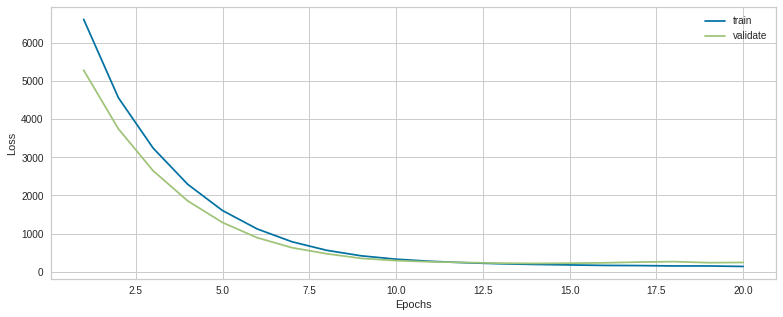

In [29]:
# plot history
def plot_loss(fit_history):
    plt.figure(figsize=(13,5))
    plt.plot(range(1, len(fit_history.history['loss'])+1), fit_history.history['loss'], label='train')
    plt.plot(range(1, len(fit_history.history['val_loss'])+1), fit_history.history['val_loss'], label='validate')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_loss(history)

## Let's use the model to predict rul1 

In [30]:
def evaluate(y_true, y_hat, label='test'):
    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_hat)
    variance = r2_score(y_true, y_hat)
    print('{} set RMSE:{}, R2:{}, mae: {}'.format(label, rmse, variance, mae))

In [31]:
# predict and evaluate
y_hat_train = model.predict(train_array)
evaluate(label_array, y_hat_train, 'train')

y_hat_test = model.predict(test_array)
evaluate(rul_01, y_hat_test)

train set RMSE:12.243342399597168, R2:0.9143890474815609, mae: 8.75074577331543
test set RMSE:18.060945928794588, R2:0.8111045745186307, mae: 13.502677526473999


In [32]:
st_df = rul_01.copy()
st_df.rename(index={0: "rul_01"})
st_df['lstm_pred'] = pd.DataFrame(y_hat_test)
st_df

,0,lstm_pred
0,112,115.673843
1,98,121.550415
2,69,34.456936
3,82,74.252174
4,91,55.903709
...,...,...
95,137,116.117241
96,82,88.032608
97,59,54.192368
98,117,122.645782


In [33]:
def plot_results(predicted_data, true_data): 
    fig = plt.figure(facecolor='white') 
    plt.figure(figsize=(13,5))
    plt.plot(true_data, label='True Data') 
    plt.plot(predicted_data, label='Prediction')
    plt.title('GRU Model')
    plt.legend() 
    plt.show() 

<Figure size 576x396 with 0 Axes>

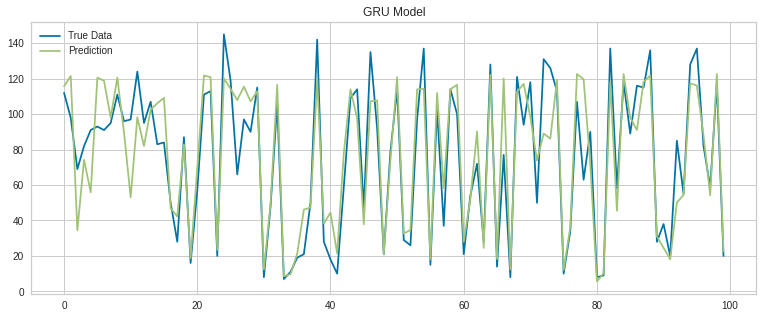

In [34]:
plot_results(y_hat_test,rul_01)

##Conclusion: Among the models trained, LSTM gives the best results 